# MIT xPro Deep Learning Capstone
### Anthony Rowlands
#### 8/18/2025

This project trains a simple chess engine neural network. It attempts to find the next best move on a chess board, given a board state.

### Github Project

The full code including data files and scripts can be found in the git repository here:

https://github.com/TitaniteSlab/mit-dl-capstone

This repo also contains a UCI protocol engine that can be used to load the trained model and actually play chess against it! (some assembly required)

### Goals

Our end goal is to get a neural network that could be used to create a custom chess engine. We'll export the trained model to Google Drive at the end so that we can download it and use it as part of a separate program that implements the engine, e.g. using the UCI protocol. The actual engine is out of scope for this notebook; here we're only interested in neural network training and analysis.

### Design

The network is a convolutional neural network classifier with 4 convolutional layers and two linear classification layers. The convolutional layers are intended to detect features (move patterns), and the classification layers reduce this down to a single best move prediction.

Additionally, in order to account for different "kinds" of moves, we have 18 channels (or "planes") to separately train each distinct element of play. The channels are:

* 1 channel per piece type, per color = 6 pieces x 2 colors = 12 channels
* 1 channel for side to move (whose turn is it)
* 4 channels for the 4 possible castling rights (white+black kingside+queenside)
* 1 channel for en passant moves
* Total: 18 channels

Input to the network is N moves of a chess game, and the target prediction is move N+1. This means that every move in a given training game provides a training input if we simply assume that every move is reasonable.

The training dataset was pulled from the Free Internet Chess Server (FICS) database, which provides every game played on the server going back many years. I downloaded all games between players rated 2000 or higher from 2024, which resulted in about 11,000 games.

Legal moves (the output layer of the network) was generated from a script. The algorithm was something like:

  * all vertical/horizontal moves (rooks, queen, pawns, king)
  * all diagonal moves (bishops, queen, pawns, king)
  * all knight moves
  * 4 castle moves
  * all promotion moves

This resulted in 1880 possible legal moves on the chess board. These are converted into a vector, and we keep hashmaps of move<->index so we can convert vector indices to/from human readable moves.

### Discussion

The model trained for 10 epochs in about 1 hour. The confusion matrix shows decent alignment between predictions and actual moves.

It's worth noting that the test data is real human games, so we're not testing against the "actual" best move, but rather the move that a human actually played. An alternative way of testing would be to use an established engine such as Stockfish to compute the best move for the position and compare to that. Another implication of training and validating against real human games is that we shouldn't expect to get much better than the humans. While the training games were limited to ELO rating games above 2000, it's still very possible (and common!) for good players to make bad moves.

Another interesting note is that there is nothing in this model or engine that knows about the rules of chess. It is simply pattern matching on moves played by humans. This means that it can sometimes predict moves that are invalid or illegal in the position. For this reason, we used softmax to get a probability distribution across all possible moves, and then we iterate down the move list (highest probability first) until we get a legal move.

In the end I'm pretty happy with the result, for only an hour of training and a relatively simple model. I played a handful of games against the engine and while I won them all, the neural net does produce reasonable moves for the most part, and even outplays me at times. Eventually it slips up and makes a not-so-good move, however. I believe with more training data it would improve.

## Environment Setup

Install 3rd party pip packages and download chess data.

We're using `python-chess` for PGN/UCI parsing and board setup.

Games for training data were downloaded from https://www.ficsgames.org/ . Some additional processing was done to remove PGN metadata, remove disconnect games, and remove games less than 5 total moves.

In [1]:
!pip install gdown chess
!mkdir -p data
!gdown --id 1-xuXCF0hYq7dBGtuJmVtryCzx9awE29H -O ./data/fics-2024.pgn
!gdown --id 1uG0Cr1MLr5Ds9yK8tN-R3lp6r8t0ZGaB -O ./data/moves_legal_uci.txt

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-xuXCF0hYq7dBGtuJmVtryCzx9awE29H
To: /content/data/fics-2024.pgn
100% 6.10M/6.10M [00:00<00:00, 22.9MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uG0Cr1MLr5Ds9yK8tN-R3lp6r8t0ZGaB
To: /content/data/moves_legal_uci.txt
100% 9.49k/9.49k [00:00<00:00, 37.9MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=8d194f842fafb02dedbd7adce74ad

## Subroutines

In [44]:
import io, json, time, copy, os
from pathlib import Path
from datetime import datetime
from zoneinfo import ZoneInfo
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import chess
import chess.pgn
from typing import List
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

from google.colab import drive

# Load all possible moves (output layer)
def load_moves():
  global move_to_index, index_to_move
  with open(MOVES_FILE, 'r', encoding='utf-8') as f:
      ALL_MOVES = [line.strip() for line in f.readlines() if line.strip()]
  move_to_index = {m: i for i, m in enumerate(ALL_MOVES)}
  index_to_move = ALL_MOVES

# Load games dataset in PGN format (training data)
def load_games():
  global pgn_lines
  with open(PGN_FILE, 'r', encoding='utf-8', errors='ignore') as f:
      pgn_lines = f.read().splitlines()

# First we parse PGN into a python-chess board, then this encodes it into a 8x8x18 tensor for input to the model
def encode_board(board: 'chess.Board') -> torch.Tensor:
    planes = np.zeros((18, 8, 8), dtype=np.float32)
    piece_type_to_index = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }
    for square, piece in board.piece_map().items():
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        base = piece_type_to_index[piece.piece_type]
        channel = base if piece.color == chess.WHITE else base + 6
        planes[channel, 7 - rank, file] = 1.0
    if board.turn == chess.WHITE:
        planes[12, :, :] = 1.0
    if board.has_kingside_castling_rights(chess.WHITE):
        planes[13, :, :] = 1.0
    if board.has_queenside_castling_rights(chess.WHITE):
        planes[14, :, :] = 1.0
    if board.has_kingside_castling_rights(chess.BLACK):
        planes[15, :, :] = 1.0
    if board.has_queenside_castling_rights(chess.BLACK):
        planes[16, :, :] = 1.0
    if board.ep_square is not None:
        r = chess.square_rank(board.ep_square)
        f = chess.square_file(board.ep_square)
        planes[17, 7 - r, f] = 1.0
    return torch.from_numpy(planes)

def collate_batch(batch):
    xs = torch.stack([b[0] for b in batch], dim=0)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys

# Calculate the accuracy of a set of predictions
def top1_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / total if total > 0 else 0.0

# Read an entire PGN file of games into an array of chess.Game objects
def parse_games_from_pgn_lines(lines: List[str]) -> List['chess.pgn.Game']:
    games = []
    for line in lines:
        if not line.strip():
            continue
        game_io = io.StringIO(line.strip())
        try:
            game = chess.pgn.read_game(game_io)
            if game is not None and game.mainline_moves() is not None:
                games.append(game)
        except Exception:
            pass
    return games

# Divide the training data into 70/15/15 train/validate/test split
def train_val_test_split(games):
    n = len(games)
    a = int(n * 0.7)
    b = int(n * 0.85)
    return games[:a], games[a:b], games[b:]

# Dataset that loads every move for each game. We treat every move in every game as a "good move" for training
class ChessNextMoveDataset(Dataset):
    def __init__(self, games, move_to_index):
        self.games = games
        self.move_to_index = move_to_index
        self.game_moves = [list(g.mainline_moves()) for g in games]
        self.sample_index = []
        for gi, moves in enumerate(self.game_moves):
            for ply_idx, move in enumerate(moves):
                uci = move.uci()
                if uci in self.move_to_index:
                    self.sample_index.append((gi, ply_idx))
    def __len__(self):
        return len(self.sample_index)
    def __getitem__(self, idx):
        gi, ply_idx = self.sample_index[idx]
        moves = self.game_moves[gi]
        board = chess.Board()
        for m in moves[:ply_idx]:
            board.push(m)
        x = encode_board(board)
        y = self.move_to_index[moves[ply_idx].uci()]
        return x, y

# Set up all the data loaders (train/validate/test)
def build_loaders(train_games, val_games, test_games, batch_size=256, num_workers=0):
    train_ds = ChessNextMoveDataset(train_games, move_to_index)
    val_ds = ChessNextMoveDataset(val_games, move_to_index)
    test_ds = ChessNextMoveDataset(test_games, move_to_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_batch)
    return {'train': train_loader, 'val': val_loader, 'test': test_loader}, {'train': len(train_ds), 'val': len(val_ds), 'test': len(test_ds)}

# Download existing model data from Google Drive and load it into the model
# I do ths so I can analyze a model even after the runtime has disconnected
def load_model():
    global model, training_curves, best_epoch, dataloaders, dataset_sizes
    print(f'Loading existing model from {LOAD_MODEL_FILE}')
    drive.mount('/content/drive')
    games = parse_games_from_pgn_lines(pgn_lines)
    train_games, val_games, test_games = train_val_test_split(games)
    dataloaders, dataset_sizes = build_loaders(train_games, val_games, test_games)
    checkpoint = torch.load(f'{MODELS_DIR}/{LOAD_MODEL_FILE}', map_location=device)
    model = ChessCNN(num_moves=len(index_to_move)).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    training_curves = {'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
    with open(LOAD_CURVES_FILE) as f:
        training_curves = json.load(f)
    best_epoch = int(checkpoint.get('best_epoch', 0))
    print(f'Loaded existing model')

# Train a fresh model
def train_model():
    global model, training_curves, best_epoch, dataloaders, dataset_sizes, num_epochs
    print('Training new model')
    def fmt(elapsed):
        m = int(elapsed // 60)
        s = int(elapsed % 60)
        return f"{m}min {s}sec"
    overall_start = time.time()
    tz = ZoneInfo('America/Denver')
    print(f"Train start: {datetime.now(tz).isoformat(timespec='seconds')}")
    games = parse_games_from_pgn_lines(pgn_lines)
    train_games, val_games, test_games = train_val_test_split(games)
    dataloaders, dataset_sizes = build_loaders(train_games, val_games, test_games)
    model = ChessCNN(num_moves=len(index_to_move)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    phases = ['train', 'val', 'test']
    training_curves = {}
    for p in phases:
        training_curves[p + '_loss'] = []
        training_curves[p + '_acc'] = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_epoch_local = 0
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        print(f"Epoch {epoch} start: {datetime.now(tz).isoformat(timespec='seconds')}")
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            count = 0
            pbar = tqdm(dataloaders[phase], desc=f"{phase} {epoch}/{num_epochs}", leave=False)
            for i, (xb, yb) in enumerate(pbar, 1):
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                preds = torch.argmax(logits, dim=1)
                running_loss += loss.item() * xb.size(0)
                running_corrects += (preds == yb).sum().item()
                count += xb.size(0)
                if count > 0:
                    pbar.set_postfix(loss=round(running_loss / count, 4), acc=round(running_corrects / count, 4), it=i)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / count if count > 0 else 0.0
            epoch_acc = running_corrects / count if count > 0 else 0.0
            training_curves[phase + '_loss'].append(epoch_loss)
            training_curves[phase + '_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_epoch_local = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        elapsed = time.time() - epoch_start
        print(f"Epoch {epoch} end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(elapsed)}")
    model.load_state_dict(best_model_wts)
    best_epoch = best_epoch_local
    total_elapsed = time.time() - overall_start
    print(f"Train end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(total_elapsed)}")
    model.eval()
    test_start = time.time()
    print(f"Test start: {datetime.now(tz).isoformat(timespec='seconds')}")
    test_all_preds = []
    test_all_trues = []
    with torch.no_grad():
        pbar = tqdm(dataloaders['test'], desc="test", leave=False)
        running = 0
        for i, (xb, yb) in enumerate(pbar, 1):
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
            test_all_preds.extend(preds)
            test_all_trues.extend(yb.numpy().tolist())
            running += xb.size(0)
            pbar.set_postfix(samples=running, it=i)
    test_elapsed = time.time() - test_start
    print(f"Test end: {datetime.now(tz).isoformat(timespec='seconds')} elapsed: {fmt(test_elapsed)}")
    training_curves['test_all_preds'] = test_all_preds
    training_curves['test_all_trues'] = test_all_trues
    print('New model trained successfully')

def draw_training_curves():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_curves['train_loss'], label='train')
    plt.plot(training_curves['val_loss'], label='val')
    plt.plot(training_curves['test_loss'], label='test')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_curves['train_acc'], label='train')
    plt.plot(training_curves['val_acc'], label='val')
    plt.plot(training_curves['test_acc'], label='test')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Draw confusion matrix. Strips any rows+cols where there are no predictions or true values
def draw_confusion_matrix():
    all_preds = training_curves.get('test_all_preds')
    all_trues = training_curves.get('test_all_trues')
    num_classes = len(index_to_move)
    counts_true = np.bincount(np.array(all_trues), minlength=num_classes)
    counts_pred = np.bincount(np.array(all_preds), minlength=num_classes)
    valid_indices = np.where((counts_true + counts_pred) > 0)[0].tolist()
    removed = num_classes - len(valid_indices)
    print({'removed_classes': int(removed), 'kept_classes': int(len(valid_indices))})
    cm = confusion_matrix(all_trues, all_preds, labels=valid_indices)
    cm_plot = cm.astype(float)
    cm_plot[cm_plot == 0] = np.nan
    plt.figure(figsize=(20, 20), dpi=100)
    im = plt.imshow(cm_plot, aspect='auto', interpolation='nearest', cmap='RdYlGn', norm=LogNorm(vmin=1, vmax=np.nanmax(cm_plot)))
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar(im)
    plt.show()

def predict_next_move_from_pgn(pgn_moves_text: str) -> tuple[str, str]:
    game_io = io.StringIO(pgn_moves_text.strip())
    game = chess.pgn.read_game(game_io)
    if game is None:
        return '', ''
    board = chess.Board()
    for m in game.mainline_moves():
        board.push(m)
    print(f"Side to move: {'white' if board.turn == chess.WHITE else 'black'}")
    x = encode_board(board).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        sorted_indices = torch.argsort(probs, dim=0, descending=True).cpu().tolist()
        for idx in sorted_indices:
            uci = index_to_move[idx]
            try:
                move = chess.Move.from_uci(uci)
            except Exception:
                continue
            if board.is_legal(move):
                san = board.san(move)
                return uci, san
    raise Exception('Model did not produce any legal move for the given position')

def save_to_drive():
    drive.mount('/content/drive')
    os.makedirs(MODELS_DIR, exist_ok=True)
    model_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    model_path = f'{MODELS_DIR}/model-{model_timestamp}.pt'
    curves_path = f'{MODELS_DIR}/training_curves-{model_timestamp}.json'
    torch.save({'model_state_dict': model.state_dict(), 'num_moves': len(index_to_move), 'best_epoch': best_epoch}, model_path)
    with open(curves_path, 'w') as f:
        json.dump(training_curves, f)
    print('Saved model to Google Drive successfully')
    print(model_path)
    print(curves_path)


## Model

In [43]:
class ChessCNN(nn.Module):
  def __init__(self, num_moves: int):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(18, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.classifier = nn.Sequential(
      nn.Linear(128 * 2 * 2, 512),
      nn.ReLU(),
      nn.Linear(512, num_moves)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x


## Globals and Hyperparameters

In [ ]:
# Globals reused across cells
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
best_epoch = 0
training_curves = {}
model = None
dataloaders = None
dataset_sizes = None
pgn_lines = []
move_to_index = {}
index_to_move = []

# User configurable variables
LOAD_EXISTING_MODEL = False # Change this if you want to load a previous model from Drive
DATA_DIR = Path('data')
MODELS_DIR = '/content/drive/MyDrive/MIT xPro Deep Learning/Capstone/models'
LOAD_MODEL_FILE = 'model.pt'
LOAD_CURVES_FILE = f'{MODELS_DIR}/training_curves.json'
MOVES_FILE = DATA_DIR.joinpath('moves_legal_uci.txt')
PGN_FILE = DATA_DIR.joinpath('fics-2024.pgn')

# Training hyperparameters
num_epochs = 10
learning_rate = 0.001
gamma = 0.9

## Main - Train or Load

In [5]:
load_moves()
load_games()

if LOAD_EXISTING_MODEL:
  load_model()
else:
  train_model()


Training new model
Train start: 2025-08-13T09:07:03-06:00
Epoch 1 start: 2025-08-13T09:07:38-06:00


Epoch 1 end: 2025-08-13T09:13:45-06:00 elapsed: 6min 7sec
Epoch 2 start: 2025-08-13T09:13:45-06:00


Epoch 2 end: 2025-08-13T09:19:37-06:00 elapsed: 5min 52sec
Epoch 3 start: 2025-08-13T09:19:37-06:00


Epoch 3 end: 2025-08-13T09:25:44-06:00 elapsed: 6min 6sec
Epoch 4 start: 2025-08-13T09:25:44-06:00


Epoch 4 end: 2025-08-13T09:31:46-06:00 elapsed: 6min 2sec
Epoch 5 start: 2025-08-13T09:31:46-06:00


Epoch 5 end: 2025-08-13T09:37:27-06:00 elapsed: 5min 40sec
Epoch 6 start: 2025-08-13T09:37:27-06:00


Epoch 6 end: 2025-08-13T09:43:07-06:00 elapsed: 5min 40sec
Epoch 7 start: 2025-08-13T09:43:07-06:00


Epoch 7 end: 2025-08-13T09:48:50-06:00 elapsed: 5min 42sec
Epoch 8 start: 2025-08-13T09:48:50-06:00


Epoch 8 end: 2025-08-13T09:54:38-06:00 elapsed: 5min 48sec
Epoch 9 start: 2025-08-13T09:54:38-06:00


Epoch 9 end: 2025-08-13T10:00:19-06:00 elapsed: 5min 40sec
Epoch 10 start: 2025-08-13T10:00:19-06:00


Epoch 10 end: 2025-08-13T10:06:03-06:00 elapsed: 5min 44sec
Train end: 2025-08-13T10:06:03-06:00 elapsed: 59min 0sec
Test start: 2025-08-13T10:06:03-06:00


Test end: 2025-08-13T10:06:49-06:00 elapsed: 0min 45sec
New model trained successfully


## Analyze

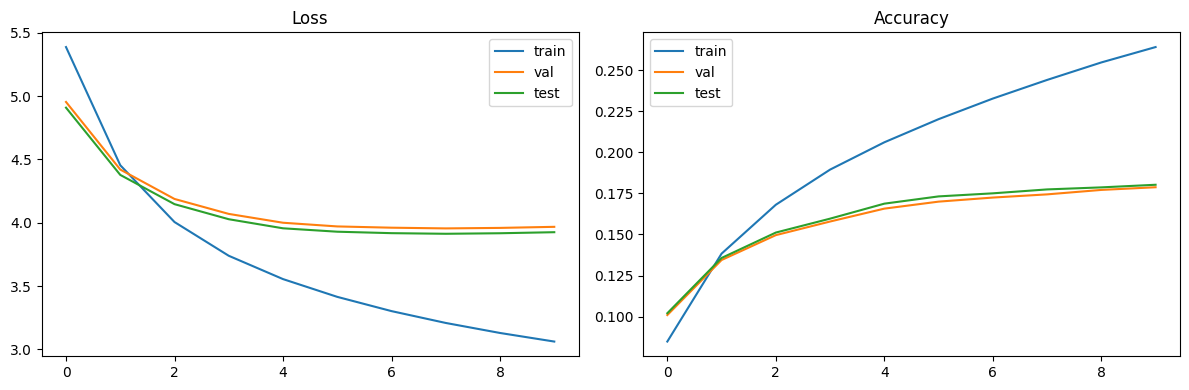

{'removed_classes': 70, 'kept_classes': 1810}


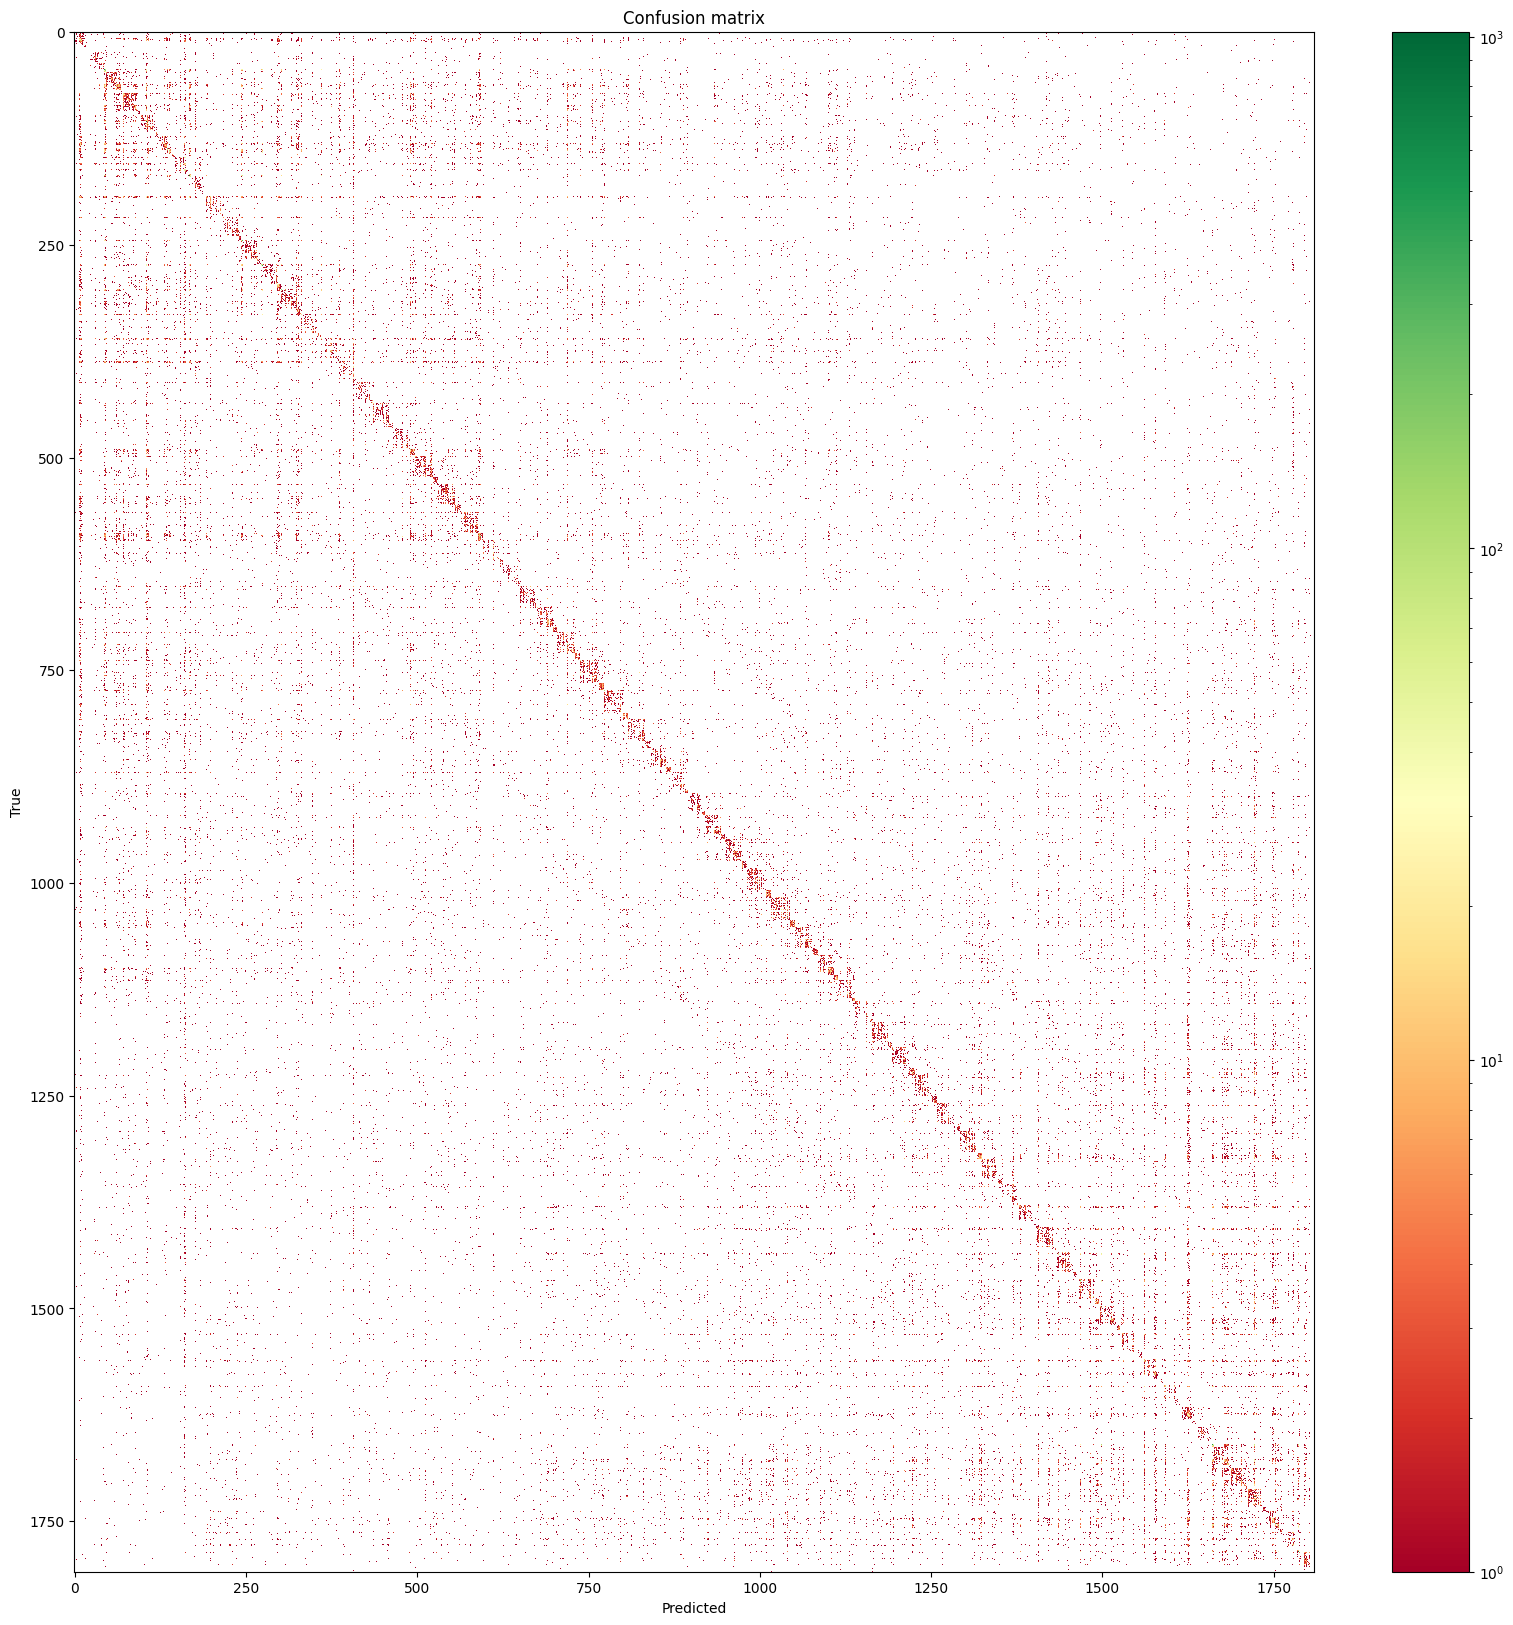

In [39]:
draw_training_curves()
draw_confusion_matrix()

## Manual Test Specific Moves

In [35]:
#TEST_GAME = "1. d4 d5 2. Nf3 Nf6 3. g3 Bf5 4. Bg2 e6 5. c4 c6 6. Nc3 h6 7. O-O Be7 8. Nd2 O-O 9. e4 dxe4 10. Ndxe4 Nbd7"
TEST_GAME = "1. d4 d5 2. Nf3 Nf6 3. g3 Bf5 4. Bg2 e6 5. c4 c6 6. Nc3 h6 7. O-O Be7 8. Nd2 O-O 9. e4 dxe4 10. Ndxe4"

uci, san = predict_next_move_from_pgn(TEST_GAME)
print(f"Next move: {uci} ({san})")

Side to move: black
Next move: f5e4 (Bxe4)


## Save Model to Drive

In [37]:
save_to_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved model to Google Drive successfully
/content/drive/MyDrive/MIT xPro Deep Learning/Capstone/models/model-20250813-163236.pt
/content/drive/MyDrive/MIT xPro Deep Learning/Capstone/models/training_curves-20250813-163236.json
